# This notebook requires the development version of require the development version of statsmodels:

#### If you wish to install the development version of statsmodel, it can be installed with the below command:

`pip install git+https://github.com/statsmodels/statsmodels.git`



In [1]:
from __future__ import absolute_import, division, print_function

from datetime import date
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

import matplotlib.pylab as plt
import seaborn as sns
% matplotlib inline

# Hide warnings during grid searching
import warnings
warnings.filterwarnings('ignore')

# Functions

In [2]:
# Plot differencing
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    diff2 = diff.diff()
    axs[0].plot(series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(diff)
    axs[1].set_title("Series of First Differences: {}".format(title))
    axs[2].plot(diff2)
    axs[2].set_title("Series of Second Differences: {}".format(title))
    return diff, diff2

# Load data

In [7]:
df = pd.read_csv('../data/SLU_total_responses_by_month.csv', header=0, index_col=1, parse_dates=[1])
df.index = pd.to_datetime(df.index)
ts = df.freq[1:-1]
ts

date
2010-07-01    109
2010-08-01     87
2010-09-01    105
2010-10-01    130
2010-11-01     81
2010-12-01     94
2011-01-01    141
2011-02-01     94
2011-03-01    123
2011-04-01    128
2011-05-01    166
2011-06-01    107
2011-07-01     88
2011-08-01    150
2011-09-01     87
2011-10-01    129
2011-11-01    106
2011-12-01    123
2012-01-01    142
2012-02-01    147
2012-03-01    138
2012-04-01    143
2012-05-01    158
2012-06-01    155
2012-07-01    139
2012-08-01    154
2012-09-01    138
2012-10-01    138
2012-11-01    119
2012-12-01    160
             ... 
2014-07-01    200
2014-08-01    180
2014-09-01    200
2014-10-01    172
2014-11-01    161
2014-12-01    163
2015-01-01    159
2015-02-01    150
2015-03-01    167
2015-04-01    203
2015-05-01    191
2015-06-01    187
2015-07-01    225
2015-08-01    189
2015-09-01    192
2015-10-01    196
2015-11-01    158
2015-12-01    169
2016-01-01    155
2016-02-01    165
2016-03-01    173
2016-04-01    196
2016-05-01    187
2016-06-01    210
2016-

In [8]:
# Examine the basic structure of the data
print('Data shape:', ts.shape, '\n')
print('First 5 observations of the data series:', '\n', ts.head())
print('\n')
print('Last 5 observations of the data series:', '\n', ts.tail())

Data shape: (78,) 

First 5 observations of the data series: 
 date
2010-07-01    109
2010-08-01     87
2010-09-01    105
2010-10-01    130
2010-11-01     81
Name: freq, dtype: int64


Last 5 observations of the data series: 
 date
2016-08-01    234
2016-09-01    181
2016-10-01    210
2016-11-01    196
2016-12-01    187
Name: freq, dtype: int64


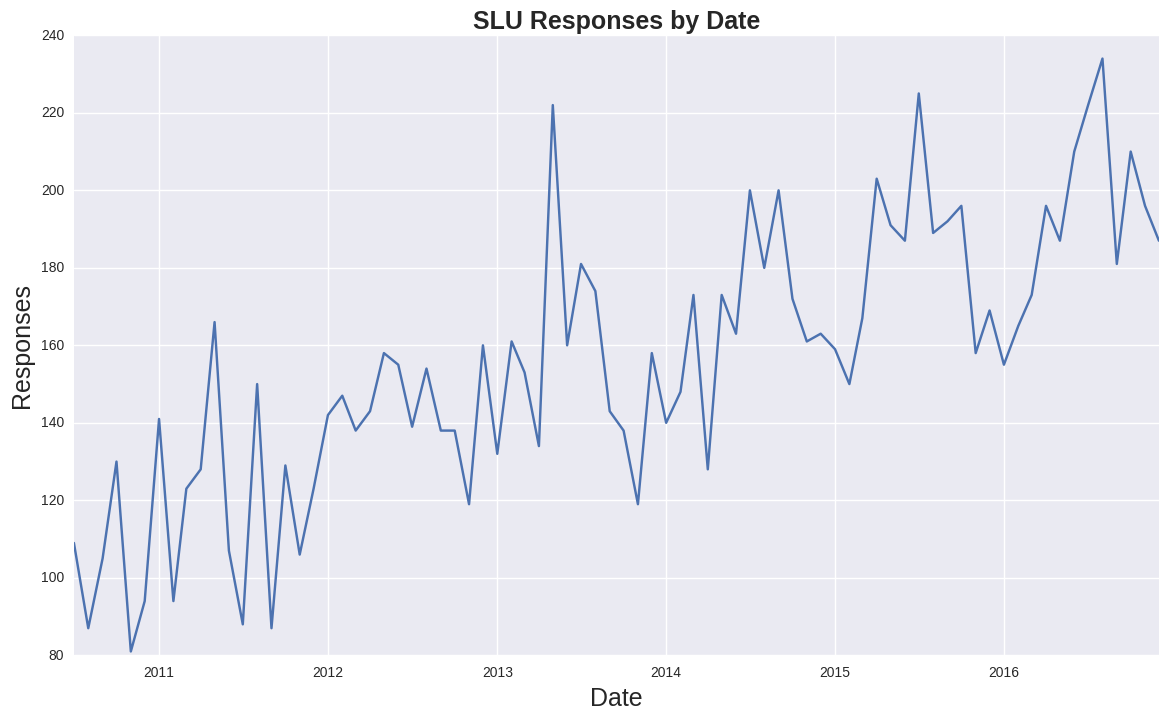

In [9]:
plt.figure(figsize=(14,8))
plt.plot(ts)
plt.title('SLU Responses by Date', fontsize=18, fontweight='bold')
plt.ylabel('Responses', fontsize=18)
plt.xlabel('Date', fontsize=18);

In [8]:
# Make test train split
ts_train = ts.iloc[:424]
ts_test  = ts.iloc[425:]
print('Training Series:', '\n', ts_train.shape, 
      '\n', ts_train.tail(), '\n')
print('Testing Series:', '\n', ts_test.shape,
      '\n', ts_test.head())

Training Series: 
 (424,) 
 date
2021-02-23    195295.146571
2021-02-24    197987.106454
2021-02-25    202403.445804
2021-02-26    183258.557071
2021-02-27    187768.674417
Name: shop_shift, dtype: float64 

Testing Series: 
 (306,) 
 date
2021-03-01    198371.776607
2021-03-02    202032.065320
2021-03-03    209499.593501
2021-03-04    214004.076915
2021-03-05    190700.457199
Name: shop_shift, dtype: float64


# Tune SARIMAX model

#### It is often best to use the differencing with lowest standard deviation. For this reason d=1 was selected for this model.

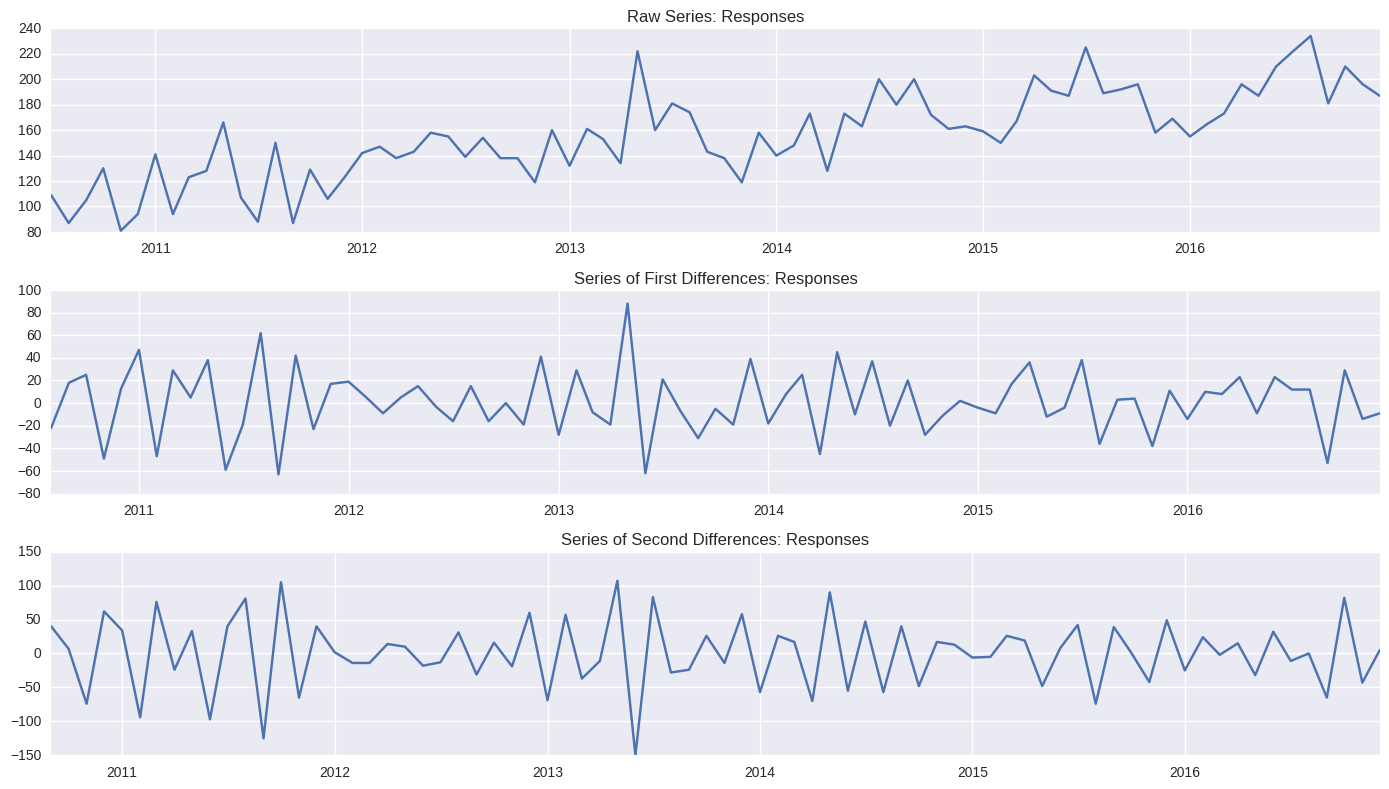

In [10]:
# Plot differencing
fig, axs = plt.subplots(3, figsize=(14, 8))
diff, diff2 = plot_series_and_difference(axs, ts, 'Responses')
fig.tight_layout()

In [11]:
print ('std dev shop_shift:       ', ts.std())
print ('std dev diff1 shop_shift: ', diff.std())
print ('std dev diff2 shop_shift: ', diff2.std())

std dev shop_shift:        35.2463406442
std dev diff1 shop_shift:  29.3609539796
std dev diff2 shop_shift:  52.2272950752


#### Find optimal p and q values with grid searching

In [16]:
parameters = [
    {'AR': 0, 'MA': 0},
    {'AR': 1, 'MA': 0},
    {'AR': 2, 'MA': 0},
    {'AR': 0, 'MA': 1},
    {'AR': 1, 'MA': 1},
    {'AR': 2, 'MA': 1},
    {'AR': 0, 'MA': 2},
    {'AR': 1, 'MA': 2},
    {'AR': 2, 'MA': 2},
]

models = {}
for params in parameters:
    try:
        models[(params['AR'], params['MA'])] = sm.tsa.statespace.SARIMAX(ts, order=(params['AR'], 1, params['MA']), seasonal_order=(0,1,0,12)).fit()
    except:
        pass
    
for model_params in models:
    print("SARIMAX({}, 1, {}) AIC: {}".format(model_params[0], model_params[1], models[model_params].aic))

SARIMAX(0, 1, 1) AIC: 601.141582687
SARIMAX(1, 1, 2) AIC: 603.848314739
SARIMAX(2, 1, 1) AIC: 602.858531092
SARIMAX(0, 1, 2) AIC: nan
SARIMAX(2, 1, 0) AIC: 606.978641621
SARIMAX(2, 1, 2) AIC: 606.107553032
SARIMAX(1, 1, 0) AIC: 618.356317157
SARIMAX(1, 1, 1) AIC: 602.11680573


#### Find optimal seasonal P and Q values with grid searching. The seasonal trend is strong so D=1 was selected (d+D should be less than or equal to 2). It is not recommended to have both P and Q greater than 0. 

In [21]:
# Find P and Q (seasonal p and q) using optimized p and p
parameters = [
    {'AR': 0, 'MA': 0},
    {'AR': 1, 'MA': 0},
    {'AR': 2, 'MA': 0},
    {'AR': 0, 'MA': 1},
    {'AR': 0, 'MA': 1},
    {'AR': 0, 'MA': 2},
]

models = {}
for params in parameters:
    try:
        models[(params['AR'], params['MA'])] = sm.tsa.statespace.SARIMAX(ts, order=(0,1,1), seasonal_order=(params['AR'], 1, params['MA'], 12)).fit()
    except:
        pass
    
for model_params in models:
    print("SARIMAX seasonal({}, 1, {}) AIC: {}".format(model_params[0], model_params[1], models[model_params].aic))

SARIMAX seasonal(0, 1, 1) AIC: 595.091181998
SARIMAX seasonal(2, 1, 0) AIC: 597.811489591
SARIMAX seasonal(1, 1, 0) AIC: 596.047943347
SARIMAX seasonal(0, 1, 0) AIC: 601.141582687


# Forecast with SARIMAX model

In [22]:
# Use optimal parameters of (0,1,1)x(0,1,1)12
mod = sm.tsa.statespace.SARIMAX(ts, order=(0,1,1), seasonal_order=(0,1,1,12))
sarima_fit2 = mod.fit()
print(sarima_fit2.summary())

                                 Statespace Model Results                                 
Dep. Variable:                               freq   No. Observations:                   78
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -294.546
Date:                            Mon, 06 Mar 2017   AIC                            595.091
Time:                                    15:35:36   BIC                            602.161
Sample:                                07-01-2010   HQIC                           597.921
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9984      1.620     -0.616      0.538      -4.174       2.177
ma.S.L12      -0.4314      0.150   

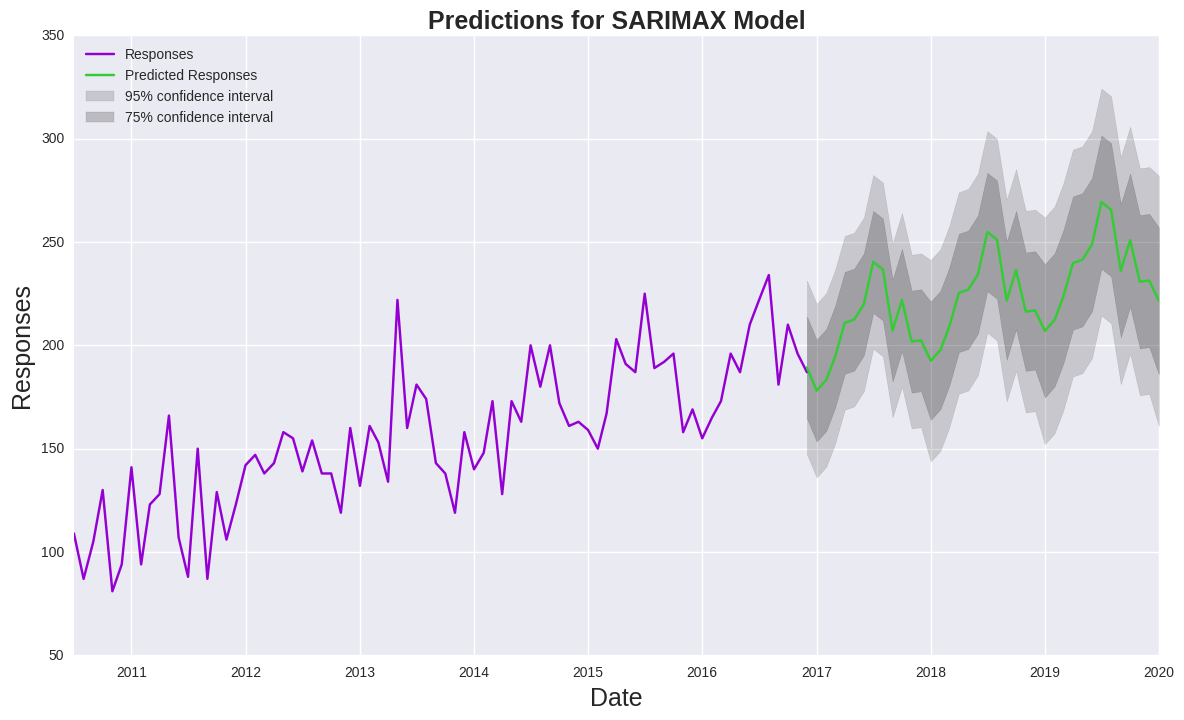

In [25]:
plt.figure(figsize=(14, 8))
plt.title("Predictions for SARIMAX Model", fontsize=18, fontweight='bold')
# plt.axvline(date(2021,3,1), color='k', linestyle=':')
# plt.axvline(date(2021,6,1), color='k', linestyle=':')

plt.plot(ts, color='darkviolet', label='Responses')
# plt.plot(ts_test, label='billboard and TV shoppers', color='royalblue')

pred_begin = date(2016,12,1)
pred_end = date(2020,1,1)
pred = sarima_fit2.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                  end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci95 = pred.conf_int(alpha=0.05)
pred_ci75 = pred.conf_int(alpha=0.25)

plt.plot(pred_mean, 'limegreen', label='Predicted Responses')
plt.fill_between(pred_ci95.index,
                 pred_ci95.iloc[:, 0],
                 pred_ci95.iloc[:, 1], color='k', alpha=0.15, label='95% confidence interval')
plt.fill_between(pred_ci75.index,
                 pred_ci75.iloc[:, 0],
                 pred_ci75.iloc[:, 1], color='k', alpha=0.2, label='75% confidence interval')
plt.xlabel("Date", fontsize=18)
plt.ylabel("Responses", fontsize=18)
plt.title
#plt.ylim(0,450000)
plt.legend(loc=2)
plt.savefig('../images/time_series.png');

# Daily Forecast With SARIMAX Model

In [68]:
df_daily = pd.read_csv('../data/SLU_total_responses_by_day.csv', header=None, index_col=0, parse_dates=[1])
df_daily.index = pd.to_datetime(df_daily.index)
df_daily[1] = df_daily[1].astype(int)
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2389 entries, 2010-06-29 to 2017-01-11
Data columns (total 1 columns):
1    2389 non-null int64
dtypes: int64(1)
memory usage: 37.3 KB


In [69]:
ts = df_daily[1]
ts

0
2010-06-29     5
2010-06-30     1
2010-07-01     6
2010-07-02     4
2010-07-03     4
2010-07-04     6
2010-07-05     3
2010-07-06     4
2010-07-07     3
2010-07-08     4
2010-07-09     1
2010-07-10     5
2010-07-11     4
2010-07-12     0
2010-07-13     1
2010-07-14     2
2010-07-15     3
2010-07-16     3
2010-07-17     4
2010-07-18     5
2010-07-19     4
2010-07-20     6
2010-07-21     5
2010-07-22     5
2010-07-23     4
2010-07-24     4
2010-07-25     0
2010-07-26     4
2010-07-27     4
2010-07-28     5
              ..
2016-12-13     6
2016-12-14     4
2016-12-15     9
2016-12-16     3
2016-12-17     2
2016-12-18     5
2016-12-19     5
2016-12-20     3
2016-12-21     6
2016-12-22     6
2016-12-23     6
2016-12-24     4
2016-12-25     6
2016-12-26     9
2016-12-27     6
2016-12-28    11
2016-12-29     6
2016-12-30     7
2016-12-31     9
2017-01-01     8
2017-01-02     4
2017-01-03    10
2017-01-04    14
2017-01-05     8
2017-01-06     9
2017-01-07     5
2017-01-08    12
2017-01-09  

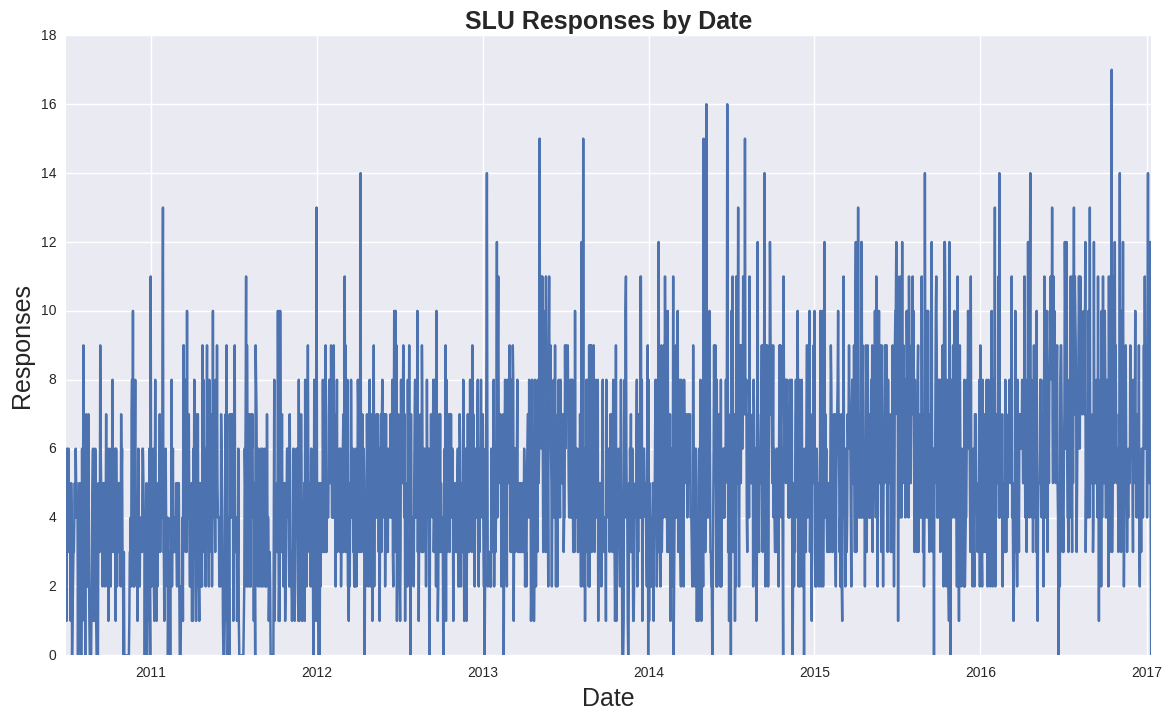

In [70]:
plt.figure(figsize=(14,8))
plt.plot(ts)
plt.title('SLU Responses by Date', fontsize=18, fontweight='bold')
plt.ylabel('Responses', fontsize=18)
plt.xlabel('Date', fontsize=18);

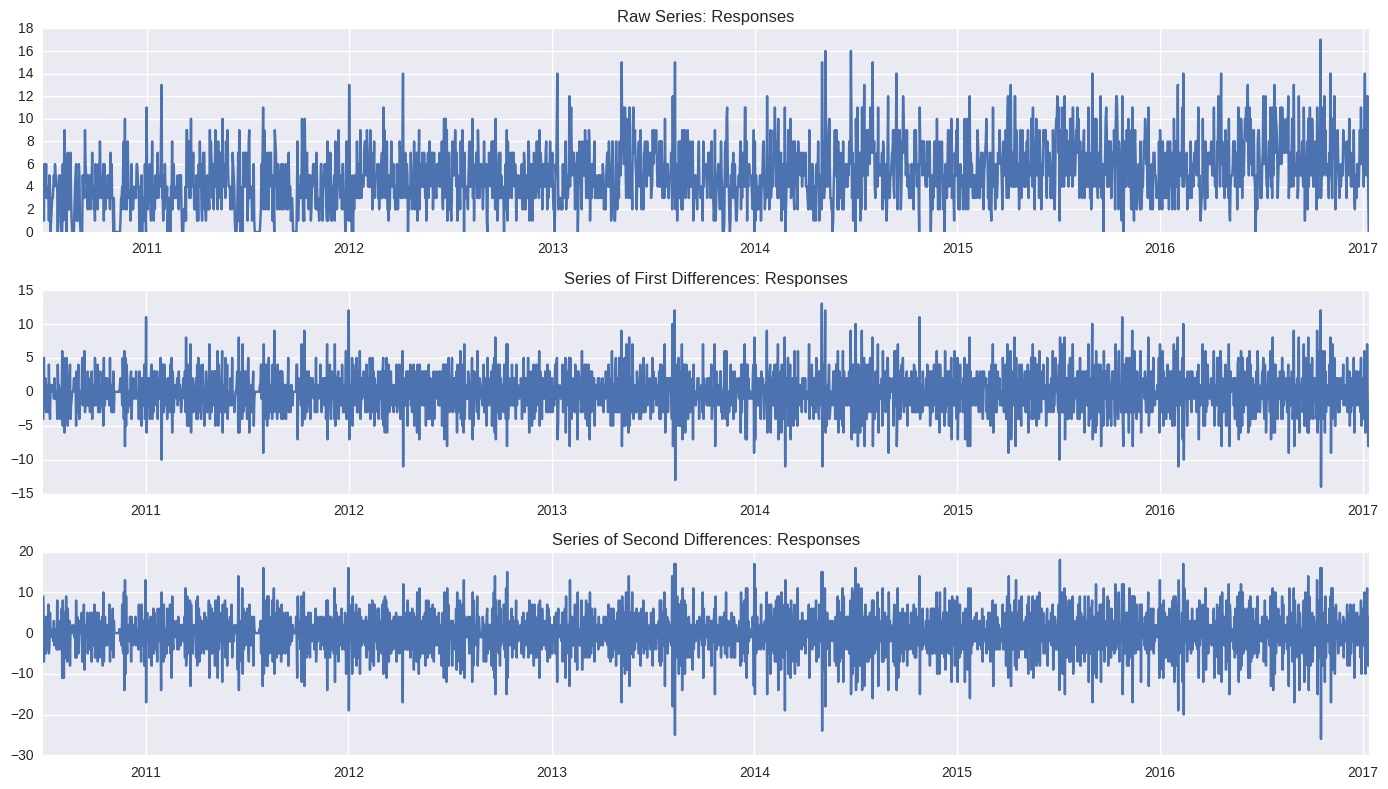

In [71]:
# Plot differencing
fig, axs = plt.subplots(3, figsize=(14, 8))
diff, diff2 = plot_series_and_difference(axs, ts, 'Responses')
fig.tight_layout()

In [72]:
print ('std dev shop_shift:       ', ts.std())
print ('std dev diff1 shop_shift: ', diff.std())
print ('std dev diff2 shop_shift: ', diff2.std())

std dev shop_shift:        2.72014908941
std dev diff1 shop_shift:  3.38266048067
std dev diff2 shop_shift:  5.80927662337


In [ ]:
parameters = [
    {'AR': 0, 'MA': 0},
    {'AR': 1, 'MA': 0},
    {'AR': 2, 'MA': 0},
    {'AR': 0, 'MA': 1},
    {'AR': 1, 'MA': 1},
    {'AR': 2, 'MA': 1},
    {'AR': 0, 'MA': 2},
    {'AR': 1, 'MA': 2},
    {'AR': 2, 'MA': 2},
]

models = {}
for params in parameters:
    try:
        models[(params['AR'], params['MA'])] = sm.tsa.statespace.SARIMAX(ts, order=(params['AR'], 1, params['MA']), seasonal_order=(0,1,0,365)).fit()
    except:
        pass
    
for model_params in models:
    print("SARIMAX({}, 1, {}) AIC: {}".format(model_params[0], model_params[1], models[model_params].aic))

In [ ]:
# Find P and Q (seasonal p and q) using optimized p and p
parameters = [
    {'AR': 0, 'MA': 0},
    {'AR': 1, 'MA': 0},
    {'AR': 2, 'MA': 0},
    {'AR': 0, 'MA': 1},
    {'AR': 0, 'MA': 1},
    {'AR': 0, 'MA': 2},
]

models = {}
for params in parameters:
    try:
        models[(params['AR'], params['MA'])] = sm.tsa.statespace.SARIMAX(ts, order=(0,1,1), seasonal_order=(params['AR'], 1, params['MA'], 12)).fit()
    except:
        pass
    
for model_params in models:
    print("SARIMAX seasonal({}, 1, {}) AIC: {}".format(model_params[0], model_params[1], models[model_params].aic))

In [ ]:
# Use optimal parameters of (0,1,1)x(0,1,1)12
mod = sm.tsa.statespace.SARIMAX(ts, order=(0,1,1), seasonal_order=(0,1,1,12))
sarima_fit2 = mod.fit()
print(sarima_fit2.summary())

In [ ]:
plt.figure(figsize=(14, 8))
plt.title("Predictions for SARIMAX Model", fontsize=18, fontweight='bold')
# plt.axvline(date(2021,3,1), color='k', linestyle=':')
# plt.axvline(date(2021,6,1), color='k', linestyle=':')

plt.plot(ts, color='darkviolet', label='Responses')
# plt.plot(ts_test, label='billboard and TV shoppers', color='royalblue')

pred_begin = date(2016,12,1)
pred_end = date(2020,1,1)
pred = sarima_fit2.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                  end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci95 = pred.conf_int(alpha=0.05)
pred_ci75 = pred.conf_int(alpha=0.25)

plt.plot(pred_mean, 'limegreen', label='Predicted Responses')
plt.fill_between(pred_ci95.index,
                 pred_ci95.iloc[:, 0],
                 pred_ci95.iloc[:, 1], color='k', alpha=0.15, label='95% confidence interval')
plt.fill_between(pred_ci75.index,
                 pred_ci75.iloc[:, 0],
                 pred_ci75.iloc[:, 1], color='k', alpha=0.2, label='75% confidence interval')
plt.xlabel("Date", fontsize=18)
plt.ylabel("Responses", fontsize=18)
plt.title
#plt.ylim(0,450000)
plt.legend(loc=2)
plt.savefig('../images/daily_time_series.png');

# Find residuals and save results

In [14]:
# Remove shift for 2021 data and find lift
preds = pred_mean[2:] - df['shift'].max()
shoppers = ts_test - df['shift'].max()
df_results = pd.concat([shoppers, preds], axis=1)
df_results.columns = ['shoppers', 'preds']
df_results['residuals'] = df_results.shoppers - df_results.preds
df_results = df_results.reset_index()
df_results.columns = ['date', 'shoppers', 'preds', 'residuals']

In [15]:
# Find weekly lift
per = df_results.date.dt.to_period("W")
g = df_results.groupby(per)
df_week = g.sum()
df_week['per_lift'] = df_week.residuals * 100 / df_week.preds
df_week['lift_change'] = df_week.per_lift.diff()
df_week.head()

,shoppers,preds,residuals,per_lift,lift_change
date,,,,,
2021-03-01/2021-03-07,1.051307e+06,7.344051e+05,21197.341992,2.886328,NaN
2021-03-08/2021-03-14,1.138761e+06,1.058071e+06,80690.570609,7.626197,4.739869
2021-03-15/2021-03-21,1.204600e+06,1.090505e+06,114094.745485,10.462560,2.836363
2021-03-22/2021-03-28,1.256861e+06,1.130317e+06,126544.012361,11.195449,0.732889
2021-03-29/2021-04-04,1.306744e+06,1.152874e+06,153869.529452,13.346600,2.151151


In [16]:
# Find monthly lift
per = df_results.date.dt.to_period("M")
g = df_results.groupby(per)
df_month = g.sum()
df_month['per_lift'] = df_month.residuals * 100 / df_month.preds
df_month['lift_change'] = df_month.per_lift.diff()
df_month

,shoppers,preds,residuals,per_lift,lift_change
date,,,,,
2021-03,5.222047e+06,4.507401e+06,418941.908369,9.294533,NaN
2021-04,5.886967e+06,5.161957e+06,725010.273423,14.045261,4.750728
2021-05,6.236841e+06,5.408638e+06,828203.129428,15.312601,1.267339
2021-06,5.459935e+06,4.981380e+06,478555.601748,9.606888,-5.705712
2021-07,4.830316e+06,4.620145e+06,210170.277217,4.548997,-5.057891
2021-08,4.282679e+06,4.211563e+06,71116.491186,1.688601,-2.860396
2021-09,4.131560e+06,4.059633e+06,71926.393013,1.771746,0.083145
2021-10,4.855381e+06,4.593571e+06,261809.555333,5.699477,3.927731
2021-11,5.668076e+06,5.102497e+06,565579.476078,11.084368,5.384890


In [17]:
# Find daily lift
df_results['per_lift'] = df_results.residuals * 100 / df_results.preds
df_results['lift_change'] = df_results.per_lift.diff()
df_results.head()

,date,shoppers,preds,residuals,per_lift,lift_change
0,2021-03-01,146021.870622,NaN,NaN,NaN,NaN
1,2021-03-02,149682.159335,NaN,NaN,NaN,NaN
2,2021-03-03,157149.687516,149468.870589,7680.816927,5.138740,NaN
3,2021-03-04,161654.170930,149263.129969,12391.040961,8.301475,3.162735
4,2021-03-05,138350.551214,152533.948382,-14183.397167,-9.298518,-17.599993


In [18]:
df_week.to_csv('../data/csv/G_SARIMAX_model_results_weekly.csv')
df_month.to_csv('../data/csv/G_SARIMAX_model_results_monthly.csv')
df_results.to_csv('../data/csv/G_SARIMAX_model_results_daily.csv')

In [19]:
df_week.to_excel('../data/excel/G_SARIMAX_model_results_weekly.xlsx')
df_month.to_excel('../data/excel/G_SARIMAX_model_results_monthly.xlsx')
df_results.to_excel('../data/excel/G_SARIMAX_model_results_daily.xlsx')

# Daily lift rate and daily decay rate

In [20]:
# Find daily lift rate during TV campaign
df_results[df_results.date < date(2021,6,1)].lift_change.mean()

0.13417621519494768

In [21]:
# Find daily decay rate after TV campaign
df_results[(df_results.date >= date(2021,6,1)) &
           (df_results.date < date(2021,9,1))].lift_change.mean()

-0.14179855908489178

# Daily lift time series

In [22]:
campaign = df_results[df_results.date < date(2021,9,1)]

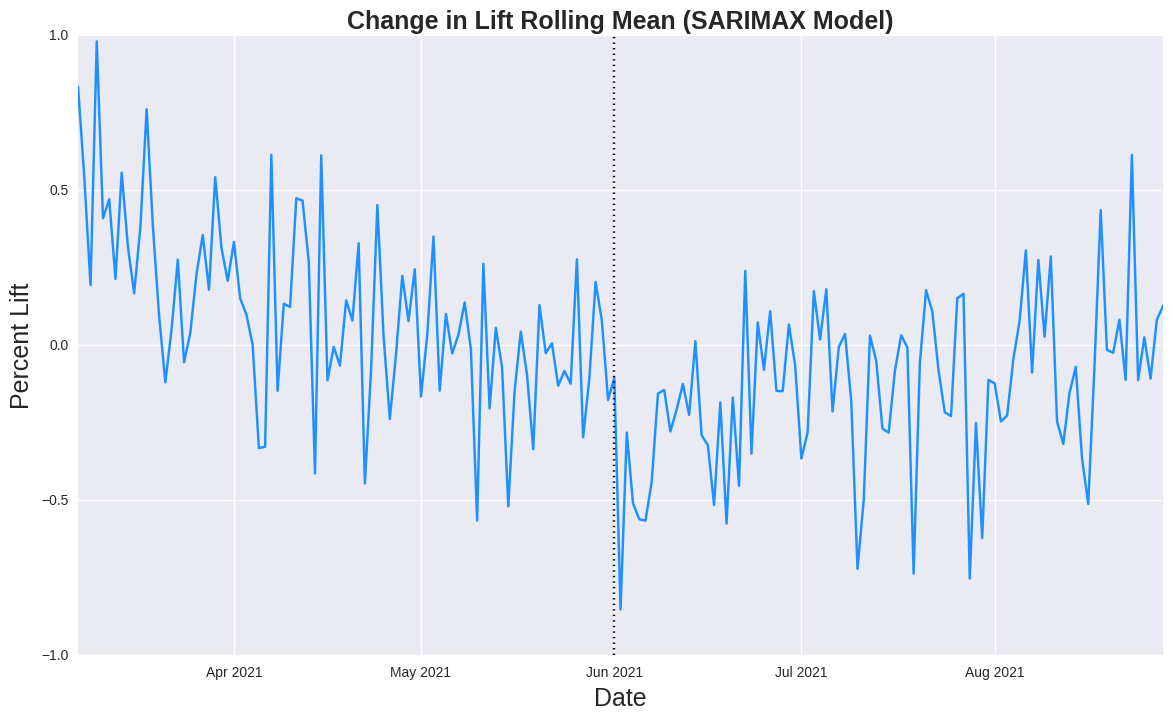

In [24]:
plt.figure(figsize=(14,8))
plt.plot(campaign.date, 
         campaign.lift_change.rolling(7, center=True).mean(), 
         color='dodgerblue')
plt.title('Change in Lift Rolling Mean (SARIMAX Model)', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=18)
plt.axvline(date(2021,6,1),linestyle=':', color='k')
plt.ylabel('Percent Lift', fontsize=18)
plt.savefig('../images/SARIMAX_model_lift_change');